In [1]:
"""
import packages
"""
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks

In [2]:
"""
import custom modules
"""
from module_.readText import read_hh
from module_.info.hh101_info import act_sep as acts
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.evaluation import episode_evaluation, all_evaluation

In [3]:
"""
0. load casas dataset: hh101
"""
with open('dataset/hh101/ann.txt','rb') as f: 
    rawdata=f.readlines()
events=read_hh(rawdata)
events=np.array(events)
print(events.shape)

"""
1. remove all sensor events except "Motion" and "Door"
"""

d_events=np.array([event for event in events if event[0][0] in ['M', 'D']])
print(d_events.shape)

"""
2. remove all sensor events with no label
"""
ld_events=np.array([event for event in d_events if event[3]!=""])

"""
3. mapping activities
"""
for i in range(ld_events.shape[0]):
    ld_events[i,-1]=acts[ld_events[i,-1]]

print(ld_events.shape)

"""
4. transition points (before-end)
"""
ld_trs=[i for i in range(ld_events.shape[0]) if i<ld_events.shape[0]-1 and ld_events[i,3]!=ld_events[i+1,3]]

"""
5. sensor list (at least once)
"""
sensor_list=list(sorted(set(ld_events[:0])))
print(sensor_list)

(322603, 4)
(219511, 4)
(149769, 4)


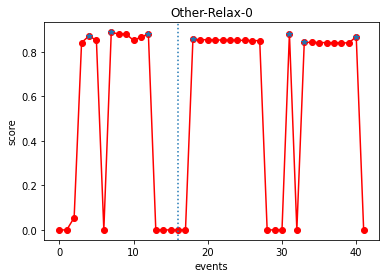

In [15]:
"""
    episodes
"""

activities=[]
previndex=0
for i, index in enumerate(ld_trs):
    if i==0:
        activities.append(ld_events[:index+1])
        previndex=index
    elif i==len(ld_trs)-1:
        activities.append(ld_events[index+1:])
    else:
        activities.append(ld_events[previndex+1:index+1])
        previndex=index

episodes=[]
eps_trs=[]
for i in range(len(activities)):
    if i==len(activities)-1:
        break
    episodes.append(np.concatenate((activities[i], activities[i+1])))
    eps_trs.append(len(activities[i]))


tpr_, fpr_ = 0, 0
tp_ = fp_ = tn_ = fn_ = 0
for e_num in range(len(episodes)):
    test_gt, test=eps_trs[e_num], episodes[e_num]
    tag="{}-{}-{}".format(test[0][-1], test[-1][-1], e_num)
    features=np.array(feature_extraction(test, "hh101", sensor_list))
    scores, _, _, _, _=change_point_detection(features, 'sep')
    scores=np.array(scores)
    non_peak=[i for i in range(len(scores)) if scores[i]>0.3]
    peak, _=find_peaks(scores)
    peak=[p for p in peak if scores[p]>0.3]
    # plt.title(tag)
    # plt.xlabel('events'); plt.ylabel('score')
    # plt.plot(range(len(scores)), scores, 'ro-')
    # plt.plot(peak, scores[peak], '*')
    # plt.axvline(x=test_gt, linestyle=':')
    break
    # ## peak-check
    # bucket={item:0 for item in ['tp','fp','tn','fn']}
    # gtb, gta=float(test[test_gt-1][2]), float(test[test_gt][2]) # time-wise
    # # gtb, gta=test_gt-1, test_gt
    # for i, event in enumerate(test):
    #     if i in peak: # positive
    #         if i==test_gt:
    #             bucket['tp']+=1
    #         else:
    #             it=float(test[i][2])
    #             if abs(it-gtb)<10 or abs(it-gta)<10:
    #             # if abs(i-gtb)<5 or abs(i-gta)<5:
    #                 bucket['tp']+=1
    #             else:
    #                 bucket['fp']+=1
    #     else: # negative
    #         if i==test_gt:
    #             bucket['fn']+=1
    #         else:
    #             bucket['tn']+=1

    # fp_+=bucket['fp']
    # print(bucket, fp_/(e_num+1))

In [5]:
"""
ALL
"""
features=np.array(feature_extraction(ld_events, 'hh101'))
scores=change_point_detection(features, 'sep', save=True)

KeyboardInterrupt: 

In [4]:
scores=np.load("features/hh_features.npy")
tp, fp, tn, fn = all_evaluation(np.array(scores), ld_events, np.array(ld_trs), 'fp')

In [5]:
print(len(tp)/(len(tp)+len(fn)))
print(len(fp)/(len(fp)+len(tn)))

0.644817374136229
0.12724596417514375


In [ ]:
"""
RuLSIF
"""

part_scores=np.array(scores)
part_scores[part_scores<0]=0
part_events=ld_events[:part]

# part_scores_sum=[]
# for i in range(len(part_scores)):
#     prev1, prev2 = max(0, i-1), max(0, i-2)
#     part_scores_sum.append(part_scores[prev1]+part_scores[prev2])
# positives_=np.array([i for i in range(len(part_scores)) if part_scores_sum[i]>0.55])
positives_=np.array([i for i in range(len(part_scores)) if part_scores[i]>0.45])
# print(positives_)
timestamps_=np.array([float(part_events[i,2]) for i in part_trs])

true_positive = false_positive = true_negative = false_negative = 0
target_positive, target_time=positives_, timestamps_
flag=True
for i, event in enumerate(part_events):
    if i in target_positive: # POSITIVE
        if i in part_trs:
            true_positive+=1
        else:
            event_time=float(event[2])
            if sum(abs(target_time-event_time)<15)!=0:
                true_positive+=1
            else:
                false_positive+=1
    else:   # NEGATIVE
        if i in part_trs:
            false_negative+=1
        else:
            true_negative+=1

print(true_positive, false_positive, true_negative, false_negative)
true_positive/(true_positive+false_negative), false_positive/(false_positive+true_negative)

In [ ]:
"""
SEP
"""
part_scores=np.array(scores)
part_events=ld_events[:part]
#part_trs

# filter -> peak
scores_1=np.where(part_scores<0.3, 0, part_scores)
print(len([i for i in scores_1 if i>0.3]))
positive_1, _=find_peaks(scores_1)
timestamp_1=[float(part_events[i,2]) for i in part_trs]
print(len(positive_1), len(timestamp_1))

# peak -> filter
peak_2, _=find_peaks(part_scores)
positive_2=[p for p in peak_2 if part_scores[p]>0.3]
timestamp_2=[float(part_events[i,2]) for i in part_trs]
print(len(positive_2), len(timestamp_2))

true_positive = false_positive = true_negative = false_negative = 0
target_positive, target_time=positive_2, np.array(timestamp_2)

for i, event in enumerate(part_events):
    if i in target_positive: # POSITIVE
        if i in part_trs:
            true_positive+=1
        else:
            event_time=float(event[2])
            if sum(abs(target_time-event_time)<10)!=0:
                true_positive+=1
            else:
                false_positive+=1
    else:   # NEGATIVE
        if i in part_trs:
            false_negative+=1
        else:
            true_negative+=1

In [ ]:
"""
RuLSIF
"""
'''
scores=np.array(scores)
# scores[scores<0]=0
scores_prevsum=[]
for i in range(len(scores)):
    prev1, prev2 = max(0, i-1), max(0, i-2)
    scores_prevsum.append(scores[prev1]+scores[prev2])

scores_prevsum=np.array(scores_prevsum)
scores_prevsum[scores_prevsum<0]=0
# peak, _ =find_peaks(scores)
# peak, _ =find_peaks(scores_prevsum)
# print(peak, test_gt)
# for idx in peak:
#     if scores[idx]>0.3:
#     plt.plot(idx, scores_prevsum[idx], 'x')
plt.bar(range(len(scores)), scores_prevsum)
for idx in ld_trs[:5]:
    plt.axvline(x=idx, linestyle=":", color='g')'''

In [ ]:
"""
0. exclude idle events,,?
"""
nonidle_events=np.array([event for event in events if event[3]!=""])
"""
0. mapping activities
"""
for i in range(nonidle_events.shape[0]):
    nonidle_events[i,-1]=acts[nonidle_events[i,-1]]
nonidle_transitions=[idx for idx in range(nonidle_events.shape[0]-1) if nonidle_events[idx,3]!=nonidle_events[idx+1,3]]

In [ ]:
activities=[]
prev_idx=0
for idx in nonidle_transitions:
    activities.append(np.array(nonidle_events[prev_idx:idx+1]).reshape((-1,4)))
    prev_idx=idx+1

In [ ]:
activities_label=[]
for item in activities:
    labels=list(set(item[:,3]))
    if len(labels)!=1:
        print("Error: {}".format(labels))
    else:
        activities_label.append(labels[0])
# len(activities_label)

In [ ]:
episodes, trs, tags=[], [], {}
for i in range(len(activities_label)):
    if i!=len(activities_label)-1:
        llabel, rlabel =activities_label[i], activities_label[i+1]
        if llabel!=rlabel:
            tags[len(trs)]=(llabel, rlabel)
            episode=np.concatenate((activities[i], activities[i+1]))
            episodes.append(episode)
            trs.append(len(activities[i]))
# len(episodes), len(trs), len(tags.values())

In [ ]:
"""
testing
"""

sample_tag="-".join(tags[0])
sample, sample_gt=episodes[0], trs[0]
sensor_list=sorted(set(sample[:,0]))
sample_windows=sliding_window(sample)

In [ ]:
# sample_tag, sample.shape, sample_gt, sensor_list, sample_windows.shape
features, scores, _, _=cpd(sample_windows, sensor_list, data_name='hh101')

In [ ]:
from module_.densityratio import Densratio as dr

test_feature=np.array(features)[0]
dre=dr(x=test_feature[:2], y=test_feature[1:])

In [ ]:
print(test_feature)
print(dre.sigma, dre.phi_x, dre.phi_y, dre.weights_)

In [ ]:
for e_num in range(len(episodes)):
    
    tag="-".join(tags[e_num])
    test, test_gt=episodes[e_num], trs[e_num]
    sensor_list=sorted(set(test[:,0]))
    windows=sliding_window(test)

    features, _, _, _=cpd(windows, sensor_list, data_name='hh101', f_only=True)
    scope=15
    # print(test_gt-scope, test_gt+scope)

    

    break

    t_lb, t_ub = max(0, test_gt-scope), min(test_gt+scope, len(test))
    transition_nearby=features[t_lb:t_ub]

    l_lb, l_ub = max(0, int(test_gt/2)-scope), min(int(test_gt/2)+scope, test_gt)
    non_range_l=features[l_lb:l_ub]

    r_lb, r_ub = max(test_gt, int(test_gt+(len(test)-test_gt)/2)-scope), min(int(test_gt+(len(test)-test_gt)/2)+scope, len(test))
    non_range_r=features[r_lb:r_ub]

    # target_features=transition_nearby
    target_features=non_range_l # *_*
    target_range=range(l_lb, l_ub) # *_*
    # if len(target_features)<2*scope:
    #     continue

    center_features=[]
    # target_features=transition_nearby
    
    for views in target_features:
        # print(views[1].shape); break
        center_features.append(views[1].reshape(1,-1))
    center_features=np.concatenate(center_features)
    # print(center_features.shape)

    time_ranges=range(0, 3)
    window_ranges=range(3, 11)
    count_ranges=range(11, 11+len(sensor_list))
    elapsed_ranges=range(11+len(sensor_list), center_features.shape[1])

    # print(sensor_list)
    # plt.ylim(-0.1, 1.1)
    # plt.margins(1, 1)
    # ncol=0
    for colnum in window_ranges:
        col=center_features[:,colnum]
        sid=-1

        if colnum<11:
            pass
        elif colnum>=11 and colnum<11+len(sensor_list):
            sid=colnum-11
            colnum=11
        else:
            sid=colnum-11-len(sensor_list)
            colnum=12
        
        if sid!=-1:
            label="{} {}".format(feature_name[colnum], sensor_list[sid])
        else:
            label=feature_name[colnum]

        # if colnum<3: # time features
        # if colnum==3: # window duration
        if colnum==4 or colnum==5: # latest sensor features
        # if colnum==6 or colnum==7 or colnum==8: # most frequent sensor features
        # if colnum==9: # entropy
        # if colnum==10: # activity level change
        # if colnum>=11 and colnum<11+len(sensor_list):
            # continue
            # if max(col)!=min(col):
            # print(col)
            plt.plot(target_range, col, label=label)
            # ncol+=1

    # print(np.array(target_features).shape)
    # print(target_range)

    feat_name='ls' # *_*
    if not os.path.exists("./analysis/hh101/{}/{}".format(tag, feat_name)):
        os.mkdir("./analysis/hh101/{}/{}".format(tag, feat_name))
    
    filename="analysis/hh101/{}/{}/l_{}_{}.png".format(tag, feat_name, e_num, test_gt)
    if filename.split("/")[-1][0]=='t':
        plt.axvline(x=test_gt, linestyle=':', color='r', label='transition')
    plt.legend()

    # plt.tight_layout()
    plt.savefig(filename)
    plt.clf()